# Query the Neo4j DB 

In [43]:
from neo4j import GraphDatabase, RoutingControl
from dotenv import load_dotenv
import os
import logging


log = logging.getLogger(__name__)

load_dotenv()
api_uri = os.getenv("NEO4J_URI")
api_usr = os.getenv("NEO4J_USR")
api_secret = os.getenv("NEO4J_PW")

driver = GraphDatabase.driver(api_uri, auth=(api_usr, api_secret))

Get unscraped users

In [145]:

round = 1
with driver.session():
    records, _, _ = driver.execute_query("""
                    WITH $this_round as this_round
                    MATCH (u:User)-[f:SCRAPED_ON]->(r:Round WHERE r.id < this_round)
                    RETURN u.uri as uri
                    ORDER  BY r  LIMIT 100
                    UNION ALL
                    MATCH (u:User) WHERE NOT (u)-[]->(:Round)
                    RETURN u.uri as uri
                    LIMIT 100""",
                            this_round=round, database="neo4j", routing_=RoutingControl.READ)
    print(records[0])

<Record uri='https://vmst.io/users/melliott'>


This is too slow. Don't run

In [ ]:
round = 1
with driver.session():
    records, _, _ = driver.execute_query("""
                    WITH $this_round as this_round
                    MATCH (u:User)-[f:SCRAPED_ON]->(r:Round {id:this_round})
                    MATCH (u) -[]->(v:User)
                    RETURN v.uri as uri, count(u) AS count 
                    ORDER BY count(u) DESC 
                    LIMIT 10""",
                            this_round=round, database="neo4j", routing_=RoutingControl.READ)
    print(records)

In [167]:

def query_db(query):
    with driver.session():
        records, _, _ = driver.execute_query(query ,
                                                  usr=api_usr,
                                                  database="neo4j",
                                                  routing_=RoutingControl.READ)
        return records



    

Users marked as scraped, by server.

In [169]:
records = query_db("""MATCH (v:User) -[]->(s:Server)
                                                    RETURN s.url as server, count(v) AS count 
                                                    ORDER BY count(v) DESC 
                                                    LIMIT 10""")

{record['server']:record['count'] for record in records}

{'https://mastodon.social': 143459,
 'https://pawoo.net': 52328,
 'https://mstdn.social': 21573,
 'https://mastodon.world': 18790,
 'https://mas.to': 18491,
 'https://misskey.io': 17850,
 'https://mastodon.online': 16473,
 'https://baraag.net': 16321,
 'https://mstdn.jp': 15989,
 'https://mastodonapp.uk': 14762}

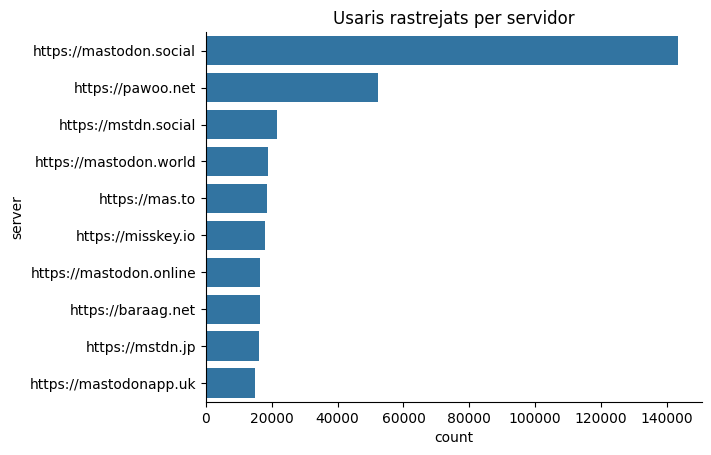

In [177]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
df = pd.DataFrame([(record['server'],record['count']) for record in records])
df.columns = ['server', 'count']

sns.barplot(data=df, y= 'server', x='count')
sns.despine()
plt.title('Usaris rastrejats per servidor')
plt.savefig('figs/nodes_scraped_per_server.png', bbox_inches="tight")
plt.show()

In [146]:
unreachable = query_db("""match (u:User)-[:SCRAPED_ON {usr_status:'NOT REACHABLE'}]->() return count(u) as count
""")

finished = query_db("""match (u:User)-[:SCRAPED_ON]->(:Round {id:1}) return count(u) as count
""")
seen = query_db("""match (u:User) return count(u) as count
""")

print("""
Total user nodes: {:,}
Nones scraped so far on round 1: {:,} ({:.2f}%)
Nodes marked as unreachable:{:,} ({:.2f}%)
""".format(seen[0]['count'],
           finished[0]['count'] - unreachable[0]['count'],
           100*(finished[0]['count'] - unreachable[0]['count'])/seen[0]['count'],
           unreachable[0]['count'],
           100*unreachable[0]['count']/seen[0]['count'])
     )


Total user nodes: 4,935,948
Nones scraped so far on round 1: 709,014 (14.36%)
Nodes marked as unreachable:47,380 (0.96%)



### Projecció de les dades. Neo4J Graph data science

Graph data science tools need to be installed on the server as a plugin.

In [52]:
from graphdatascience import GraphDataScience
gds = GraphDataScience(api_uri, auth=(api_usr, api_secret))


Check what projections we have.

In [147]:
gds.graph.list()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 0, 'max': 419749, 'p90': 12, 'p999': 1...",myGraph,neo4j,270 MiB,283194168,4918038,83013131,{'relationshipProjection': {'FOLLOWS': {'aggre...,0.000003,2024-01-12T09:45:24.259352358+01:00,2024-01-12T09:45:35.791700586+01:00,"{'graphProperties': {}, 'nodes': {'User': {}},...","{'graphProperties': {}, 'nodes': {'User': {}},..."
1,"{'min': 0, 'max': 25212, 'p90': 377, 'p999': 5...",my-su-graph,neo4j,192 MiB,201750008,109912,21956712,"{'relationshipProperties': {}, 'jobId': '75ad9...",0.001818,2024-01-09T15:47:55.159264462+01:00,2024-01-09T16:26:42.225360440+01:00,"{'graphProperties': {}, 'nodes': {'User': {'de...","{'graphProperties': {}, 'nodes': {'User': {'de..."
2,"{'min': 0, 'max': 419739, 'p90': 12, 'p999': 1...",my-graph,neo4j,None,-1,4775215,78854506,{'relationshipProjection': {'FOLLOWS': {'aggre...,0.000003,2024-01-09T15:12:57.638618546+01:00,2024-01-09T15:23:26.923020328+01:00,"{'graphProperties': {}, 'nodes': {'User': {'de...","{'graphProperties': {}, 'nodes': {'User': {'de..."


Create projection. It will fail if projection exists.

In [30]:
G, metadata = gds.graph.project(
    "my-graph", 
    "User",
    {"FOLLOWS" : {'orientation': "REVERSE"}}
)

print(metadata)

[<Record nodeProjection={'User': {'label': 'User', 'properties': {}}} relationshipProjection={'FOLLOWS': {'aggregation': 'DEFAULT', 'orientation': 'REVERSE', 'indexInverse': False, 'properties': {}, 'type': 'FOLLOWS'}} graphName='myGraph' nodeCount=4773558 relationshipCount=78585720 projectMillis=16076>]


In [17]:
G = gds.graph.get('my-graph')
gds.degree.mutate(G, mutateProperty='degree')

nodePropertiesWritten                                               4775215
centralityDistribution    {'min': 0.0, 'max': 419739.9999923706, 'p90': ...
mutateMillis                                                              3
postProcessingMillis                                                    189
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'orientation': 'NATURAL', 'mutateProperty': '...
Name: 0, dtype: object

In [31]:
gds.graph.drop(gds.graph.get('my-su-graph'))
sG = gds.beta.graph.project.subgraph('my-su-graph', G, 'n.degree > 100.0', "*")

In [32]:
sG

GraphCreateResult(graph=Graph({'graphName': 'my-su-graph', 'nodeCount': 109912, 'relationshipCount': 21361792, 'database': 'neo4j', 'configuration': {'relationshipProperties': {}, 'jobId': '75ad9c35-3ec8-4d16-848b-8bf05478bd82', 'validateRelationships': False, 'nodeFilter': 'n.degree > 100.0', 'sudo': False, 'relationshipProjection': {'FOLLOWS': {'aggregation': 'DEFAULT', 'orientation': 'REVERSE', 'indexInverse': False, 'properties': {}, 'type': 'FOLLOWS'}}, 'readConcurrency': 4, 'nodeProperties': {}, 'nodeProjection': {'User': {'label': 'User', 'properties': {}}}, 'logProgress': True, 'concurrency': 4, 'creationTime': neo4j.time.DateTime(2024, 1, 9, 15, 47, 55, 159264462, tzinfo=<DstTzInfo 'Europe/Berlin' CET+1:00:00 STD>), 'relationshipFilter': '*', 'parameters': {}}, 'schema': {'graphProperties': {}, 'nodes': {'User': {'degree': 'Float (DefaultValue(NaN), TRANSIENT)'}}, 'relationships': {'FOLLOWS': {}, 'SIMILAR': {'score': 'Float (DefaultValue(NaN), TRANSIENT, Aggregation.NONE)'}}},

In [37]:
gds.nodeSimilarity.mutate(gds.graph.get('my-su-graph'),
                          degreeCutoff= 100, topK= 10,
                                   mutateRelationshipType='sim',
                                   mutateProperty='score')

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

preProcessingMillis                                                       0
computeMillis                                                       1755022
mutateMillis                                                            192
postProcessingMillis                                                     -1
nodesCompared                                                         57052
relationshipsWritten                                                 570520
similarityDistribution    {'min': 0.013824880123138428, 'p5': 0.04972380...
configuration             {'mutateProperty': 'score', 'jobId': 'f237a571...
Name: 0, dtype: object

In [39]:
gds.graph.get('my-su-graph').relationship_properties()

similarity    [score]
sim           [score]
FOLLOWS            []
SIMILAR       [score]
dtype: object

In [42]:
gds.graph.writeRelationship(gds.graph.get('my-su-graph'),'sim',
  'score')

writeMillis                       0
graphName               my-su-graph
relationshipType                sim
relationshipProperty          score
relationshipsWritten         570520
propertiesWritten            570520
Name: 0, dtype: object

## Export and use with something else 

In [33]:
# This is for exporting
records = query_db("""
CALL gds.graph.export.csv('myGraph',  { exportName: 'my-export.csv',
                                        additionalNodeProperties: [{ uri: {defaultValue: 'nouri'}}]

})
""")

print(records)

[<Record exportName='my-export.csv' graphName='myGraph' nodeCount=4773558 relationshipCount=78585720 relationshipTypeCount=1 nodePropertyCount=4773558 relationshipPropertyCount=0 writeMillis=17511>]


Get projection.

In [53]:
g = gds.graph.get('myGraph')

In [ ]:
Degree distribution

In [55]:
g.degree_distribution()

min          0.000000
max     419749.000000
p90         12.000000
p999      1737.000000
p99        247.000000
p50          0.000000
p75          2.000000
p95         36.000000
mean        16.879319
dtype: float64

In [ ]:
records = query_db("""CALL gds.graph.export.csv('myGraph', { exportName: 'my-export', additionalNodeProperties: ['uri']})""")




In [57]:
{record for record in records}


{<Record exportName='my-export' graphName='myGraph' nodeCount=4918038 relationshipCount=83013131 relationshipTypeCount=1 nodePropertyCount=4918038 relationshipPropertyCount=0 writeMillis=17940>}

## Use data in csv exports

These are large files. Let's see how big they are.

In [157]:
import glob
import os

from urllib.parse import urlparse
from collections import defaultdict
# relative path to search all text files
files = glob.glob("../neo4jexports/export/my-export/nodes_User_[0-9]*.csv")
print(files)

['../neo4jexports/export/my-export/nodes_User_3.csv', '../neo4jexports/export/my-export/nodes_User_1.csv', '../neo4jexports/export/my-export/nodes_User_2.csv', '../neo4jexports/export/my-export/nodes_User_0.csv']


In [154]:
!wc -l ../neo4jexports/export/my-export/nodes_User_[0-9]*.csv

  1230000 ../neo4jexports/export/my-export/nodes_User_0.csv
  1220000 ../neo4jexports/export/my-export/nodes_User_1.csv
  1230000 ../neo4jexports/export/my-export/nodes_User_2.csv
  1238038 ../neo4jexports/export/my-export/nodes_User_3.csv
  4918038 total


As expected. We have 5 million nodes, we get 5 million lines.We have also relationships in other files amounting to 83 million.


Now let's get a count of servers. We need to strip the `/user/user_handle` part of the uri.
Let's peak at the `uri`.


In [163]:
!head -n 1 ../neo4jexports/export/my-export/nodes_User_[0-9]*.csv

==> ../neo4jexports/export/my-export/nodes_User_0.csv <==
115200,"https://mentalhealth.social/users/stillalivestillsmiling"

==> ../neo4jexports/export/my-export/nodes_User_1.csv <==
145205,"https://mastodont.cat/users/socenperdi"

==> ../neo4jexports/export/my-export/nodes_User_2.csv <==
125200,"https://nerdculture.de/users/chipkali"

==> ../neo4jexports/export/my-export/nodes_User_3.csv <==
135204,"https://mastodon.social/users/KINGPRAIZ"


In [ ]:
# let's get a dict of server -> size
servers = defaultdict(int)
for file in files:
    with open(file) as f:
        ls = f.readlines()
        for l in ls:
            parsed = urlparse(l.split(',')[1].strip('"'))
            servers[parsed.netloc] +=1

Now we know how many servers we have:

In [164]:
len (servers)

51677

In [110]:
import seaborn as sns
import pandas as pd

servers_df = pd.DataFrame.from_dict(servers, orient='index', columns=['n_users'])
servers_df.reset_index(level=0, inplace=True)
bigger_15 = servers_df.sort_values('n_users', ascending=False)[:20].copy()
bigger_15

,index,n_users
0,mastodon.social,772285
479,pawoo.net,432709
109,misskey.io,158672
41,mstdn.social,138423
1053,baraag.net,128652
84,mstdn.jp,113848
97,mastodon.online,108435
20,mastodon.world,103492
17,mas.to,103145
2850,bird.makeup,78364


In [111]:
# We add the sum of other servers
others_count = servers_df['n_users'].sum() - bigger_15['n_users'].sum()
others_df = pd.DataFrame([['Other servers', others_count]], columns=['index','n_users'])
bigger_15 =  pd.concat([bigger_15, others_df])

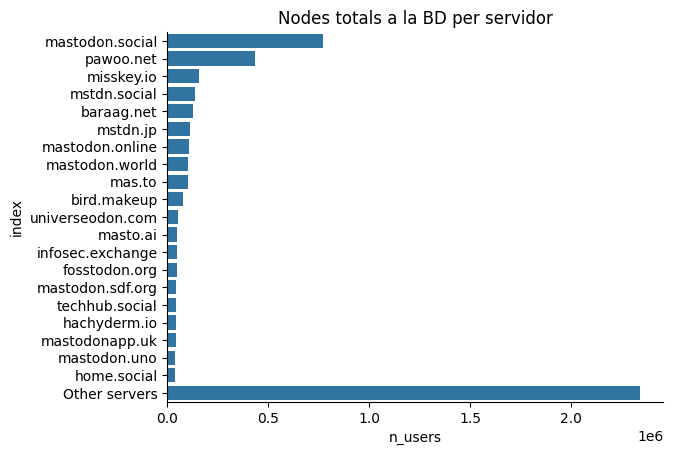

In [178]:

sns.barplot(data=bigger_15, y= 'index', x='n_users')
sns.despine()
plt.title('Nodes totals a la BD per servidor')
plt.savefig('figs/total_nodes_by_server.png',bbox_inches="tight")
plt.show()

Wow. A lot of people are in other servers. So, where are the people, in big or small servers?

In [119]:
bins = pd.IntervalIndex.from_tuples([(0, 9), (10, 99), (100, 999), (1000, 9999),(10000, 99999),(100000, servers_df.n_users.max()+1)])

servers_df['server_size'] = pd.cut(servers_df.n_users, bins)

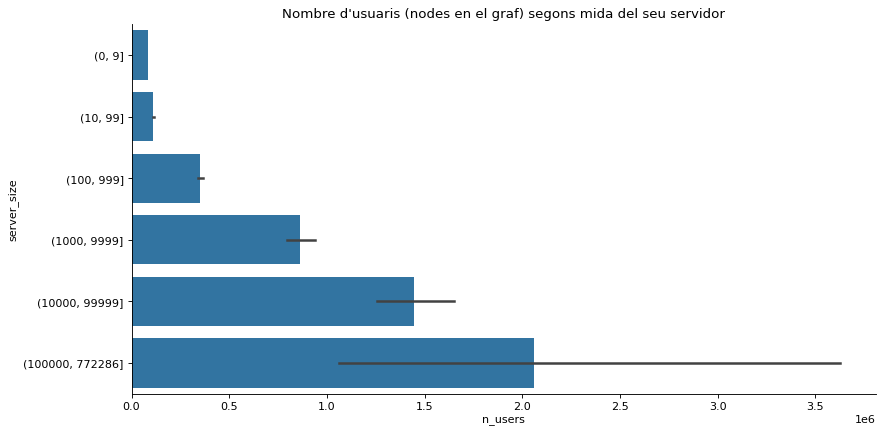

In [179]:
plt.figure(figsize=(12, 6), dpi=80)
sns.barplot(data=servers_df, y= 'server_size', x='n_users',  estimator="sum")
sns.despine()
plt.title('Nombre d\'usuaris (nodes en el graf) segons mida del seu servidor')
plt.savefig('figs/users_by_node_size.png',bbox_inches="tight")
plt.show()

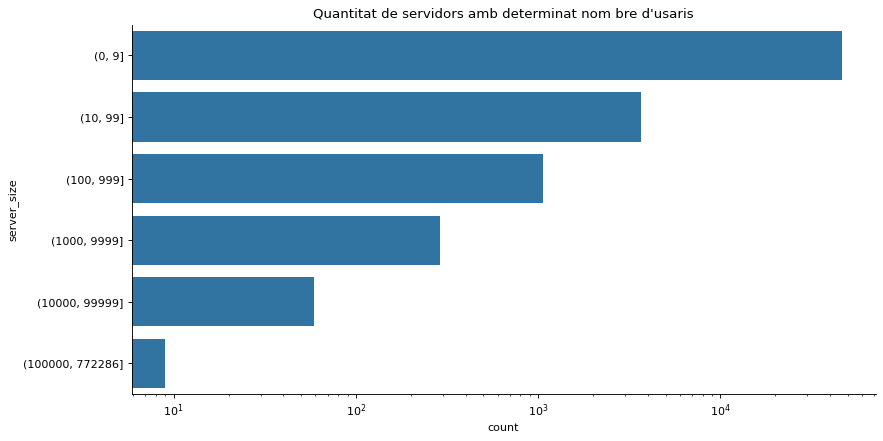

In [180]:
plt.figure(figsize=(12, 6), dpi=80)
ax = sns.countplot(data=servers_df, y='server_size')
ax.set_xscale('log')
sns.despine()
plt.title('Quantitat de servidors amb determinat nom bre d\'usaris')

plt.savefig('figs/server_count_by_server_size.png',bbox_inches="tight")

plt.show()


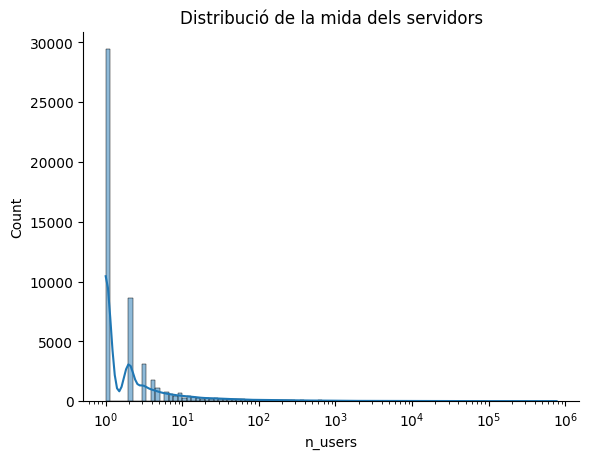

In [181]:
sns.histplot(data=servers_df, x='n_users', bins=100,  log_scale=True, kde=True)
sns.despine()
plt.title('Distribució de la mida dels servidors')
plt.savefig('figs/server_size_distribution.png',bbox_inches="tight")

plt.show()